In [2]:
import optuna

# Torch
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import DataLoader, HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear, GATv2Conv, TransformerConv
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

# Misc
import os, sys
import time
from math import ceil
import random
from IPython.display import clear_output
from termcolor import colored

# CS2
sys.path.append(os.path.abspath('../../package'))
from CS2.visualize import HeteroGNNRoundAnalyzer

# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_TEMP_GRAPH_DATA = '../../data/matches-processed/cs2/temporal-hetero-graph/'
PATH_MODELS = '../../model/tgn/'
BATCH_SIZE = 100

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Static round probabilities

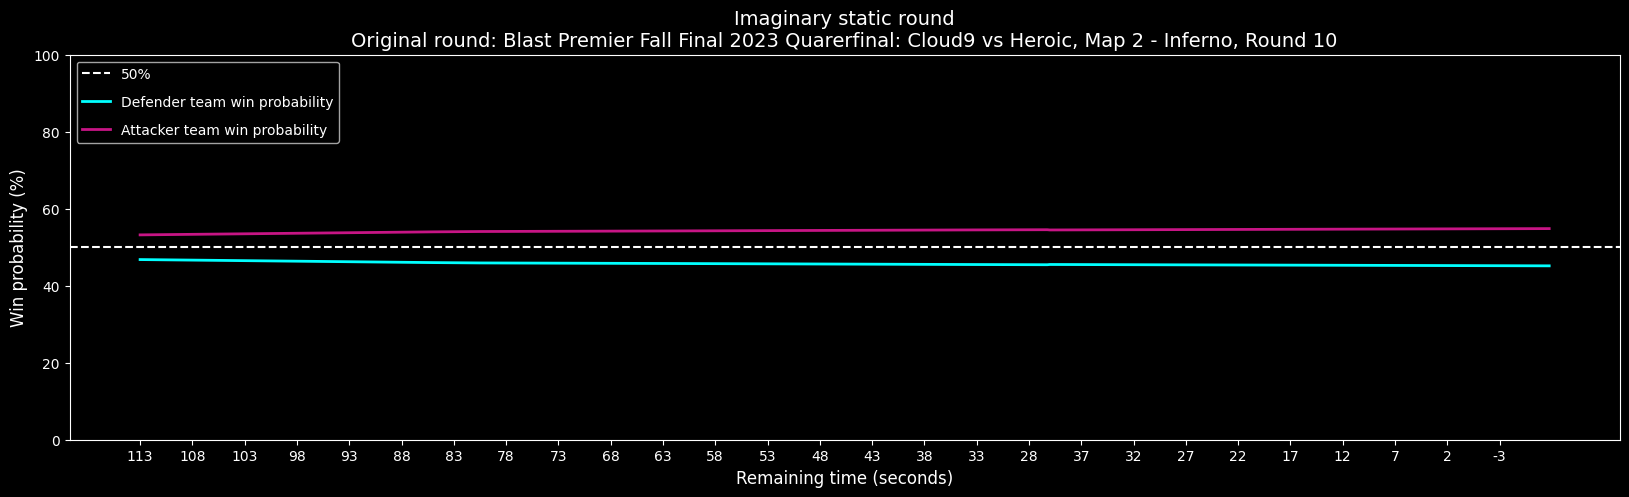

In [20]:
# Read the model class txt file
model_folder = '241020_2/'
model_class_code = ''
with open(PATH_MODELS + model_folder + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()

# Run the model class code
exec(model_class_code)

# Model
model = torch.load(PATH_MODELS + model_folder + 'epoch_2.pt', weights_only=False)

# Static Data
# Round 1 - Pistol economy (Ts won)
# Round 2 - CT: Eco, T: Semi-full buy (Ts won)
# Round 4 - CT: Full buy, T: Full buy (CTs won)
data  = torch.load(PATH_TEMP_GRAPH_DATA + 'static_rounds_100000.pt', weights_only=False)

# Analyze round
analyzer = HeteroGNNRoundAnalyzer()

# Round 1
# analyzer.analyze_round(data, model, 1, plt_title='Imaginary static round\nCT equipment: Pistol, T equipment: Pistol\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 1')

# Round 2
# analyzer.analyze_round(data, model, 2, plt_title='Imaginary static round\nCT equipment: Eco (Lost pistol), T equipment: Semi-full buy (Won pistol)\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 2')

# Round 3
# analyzer.analyze_round(data, model, 3, plt_title='Imaginary static round\nCT equipment: Full-buy, T equipment: Full-buy\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 4 (modified)')

# Round 4
# analyzer.analyze_round(data, model, 4, plt_title='Imaginary static round\nCT equipment: Full-buy, T equipment: Full-buy\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round 4')

# Other round
round_num = 10
analyzer.analyze_round(data, model, round_num, plt_title=f'Imaginary static round\nOriginal round: Blast Premier Fall Final 2023 Quarerfinal: Cloud9 vs Heroic, Map 2 - Inferno, Round {round_num}')

#### Workflow code

In [3]:
# Read the model class txt file
model_folder = '241020_2/'
model_class_code = ''
with open(PATH_MODELS + model_folder + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()

# Run the model class code
exec(model_class_code)

# Model
model = torch.load(PATH_MODELS + model_folder + 'epoch_2.pt', weights_only=False)

# Data
data  = torch.load(PATH_TEMP_GRAPH_DATA + '100000.pt', weights_only=False)

In [11]:
def get_static_round(data, round_num):

    # --------------------------------------------------
    #      Get the graphs for the round selected
    # --------------------------------------------------

    selected_round = []

    for dyn_graph in data:

        if dyn_graph[0].y['round'] == np.float32(round_num):
            selected_round.append(dyn_graph)

    actual_time = 1
    filtered_selected_round = []

    for dyn_graph in selected_round:
        if (dyn_graph[-1].y['remaining_time'] < actual_time) or \
        (dyn_graph[-1].y['remaining_time'] > actual_time and dyn_graph[-1].y['remaining_time'] < 0.9):
            actual_time = dyn_graph[-1].y['remaining_time'] 
            filtered_selected_round.append(dyn_graph)
        else:
            break


    # --------------------------------------------------
    #      Get the static round
    # --------------------------------------------------

    first_frame_map = filtered_selected_round[0][0]['map'].x
    first_frame_player = filtered_selected_round[0][0]['player'].x
    first_frame_player[:, 5:8] = torch.zeros([10, 3])

    first_frame_player_edges = filtered_selected_round[0][0][('player', 'closest_to', 'map')].edge_index

    first_frame_y = filtered_selected_round[0][0].y

    static_round = []

    for dyn_graph in filtered_selected_round:
        
        static_dyn_graph = []
        
        for graph in dyn_graph:

            static_graph = HeteroData()
            static_graph['map'].x = first_frame_map
            static_graph['player'].x = first_frame_player
            static_graph[('player', 'is', 'player')].edge_index = graph[('player', 'is', 'player')].edge_index
            static_graph[('player', 'closest_to', 'map')].edge_index = first_frame_player_edges
            static_graph[('map', 'connected_to', 'map')].edge_index = graph[('map', 'connected_to', 'map')].edge_index

            remaining_time = graph.y['remaining_time']
            time = graph.y['time']
            freeze_end = graph.y['freeze_end']
            end = graph.y['end']

            static_graph.y = {
                'tick': first_frame_y['tick'],
                'round': first_frame_y['round'],
                'time': time,
                'remaining_time': remaining_time,
                'freeze_end': freeze_end,
                'end': end,
                'CT_score': first_frame_y['CT_score'],
                'T_score': first_frame_y['T_score'],
                'CT_alive_num': first_frame_y['CT_alive_num'],
                'T_alive_num': first_frame_y['T_alive_num'],
                'CT_total_hp': first_frame_y['CT_total_hp'],
                'T_total_hp': first_frame_y['T_total_hp'],
                'CT_equipment_value': first_frame_y['CT_equipment_value'],
                'T_equipment_value': first_frame_y['T_equipment_value'],
                'CT_losing_streak': 0.0,
                'T_losing_streak': min(1.0, first_frame_y['round']),
                'is_bomb_dropped': 0.0,
                'is_bomb_being_planted': 0.0,
                'is_bomb_being_defused': 0.0,
                'is_bomb_defused': 0.0,
                'is_bomb_planted_at_A_site': 0.0,
                'is_bomb_planted_at_B_site': 0.0,
                'bomb_X': 0.0,
                'bomb_Y': 0.0,
                'bomb_Z': 0.0,
                'bomb_mx_pos1': 0.0,
                'bomb_mx_pos2': 0.0,
                'bomb_mx_pos3': 0.0,
                'bomb_mx_pos4': 0.0,
                'bomb_mx_pos5': 0.0,
                'bomb_mx_pos6': 0.0,
                'bomb_mx_pos7': 0.0,
                'bomb_mx_pos8': 0.0,
                'bomb_mx_pos9': 0.0,
                'CT_wins': 1.0,
            }

            static_dyn_graph.append(static_graph)

        static_round.append(static_dyn_graph)

    return static_round

In [12]:
rounds = []

# Collect rounds
for graph in data:
    if graph[0].y['round'] not in rounds:
        rounds.append(graph[0].y['round'])

static_rounds = []

for round_num in rounds:
    static_rounds.extend(get_static_round(data, round_num))

In [15]:
torch.save(static_rounds, PATH_TEMP_GRAPH_DATA + 'static_rounds_100000.pt')